In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from AAdam01 import AAdam
from modifiedAdam import ModifiedAdam


class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    h6 = H6Layer(h4,h5)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h6(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
modelAAdam = build_model(input_shape, filters)
optimizer = ModifiedAdam(learning_rate=0.001) # Reduce learning rate
modelAAdam.compile(optimizer=optimizer, loss='mse')


In [2]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

# X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 150

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = modelAAdam.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/150
158/158 [==============================] - 3s 3ms/step - loss: 0.3532 - val_loss: 0.0633
Epoch 2/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0504 - val_loss: 0.0514
Epoch 3/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0399 - val_loss: 0.0320
Epoch 4/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0088
Epoch 5/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 5.5960e-04
Epoch 6/150
158/158 [==============================] - 0s 1ms/step - loss: 5.4020e-04 - val_loss: 4.6901e-04
Epoch 7/150
158/158 [==============================] - 0s 1ms/step - loss: 2.8067e-04 - val_loss: 2.1261e-04
Epoch 8/150
158/158 [==============================] - 0s 1ms/step - loss: 2.4108e-04 - val_loss: 1.5416e-04
Epoch 9/150
158/158 [==============================] - 0s 1ms/step - loss: 3.4816e-04 - val_loss: 1.7904e-04
Epoch 10/150
158/158 [==============================] -

Validation loss: 0.00027383730048313737
32/32 [==============================] - 0s 640us/step


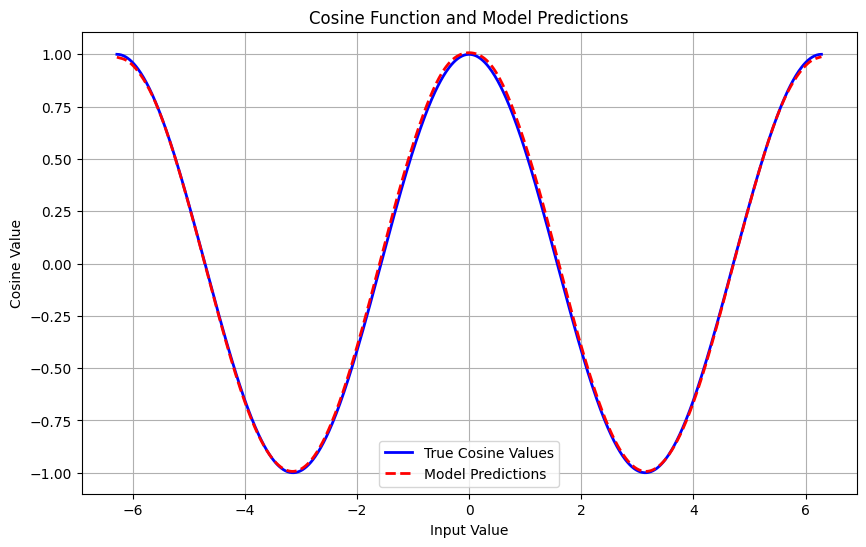

In [3]:
val_loss = modelAAdam.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelAAdam.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# REGULAR ADAM

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from modifiedAdam import ModifiedAdam


class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    h6 = H6Layer(h4,h5)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h6(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
model = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model.compile(optimizer=optimizer, loss='mse')


In [5]:
import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

# X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 150

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/150
158/158 [==============================] - 3s 3ms/step - loss: 0.6401 - val_loss: 0.5048
Epoch 2/150
158/158 [==============================] - 0s 1ms/step - loss: 0.2490 - val_loss: 0.0029
Epoch 3/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 4/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/150
158/158 [==============================] - 0s 1ms/step - loss: 3.6935e-04 - val_loss: 2.0177e-04
Epoch 6/150
158/158 [==============================] - 0s 1ms/step - loss: 5.3244e-04 - val_loss: 0.0010
Epoch 7/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 6.2550e-04
Epoch 8/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 9/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 3.1705e-04
Epoch 10/150
158/158 [==============================] - 0s 1ms/step - l

Validation loss: 0.0006334553472697735
32/32 [==============================] - 0s 608us/step


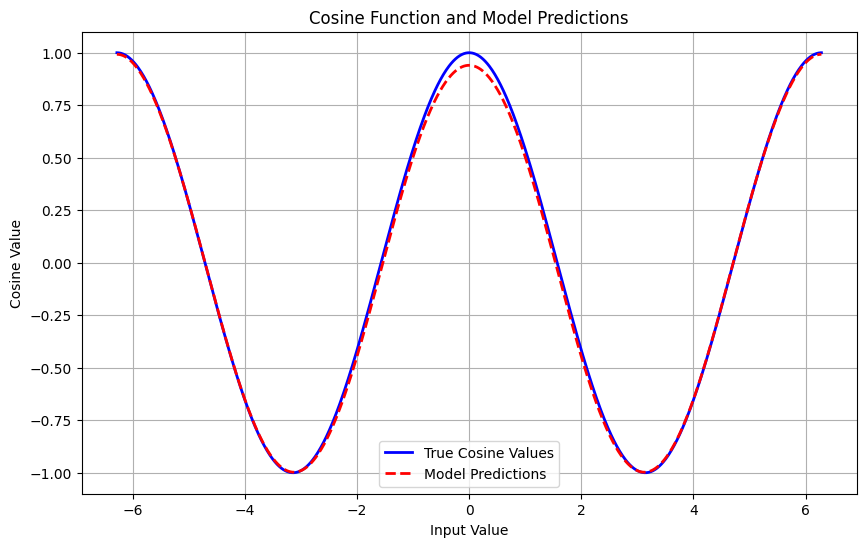

In [6]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()
